## Reinforcement Learning in R

Nicolas Pröllochs
2020-03-02

This vignette gives an introduction to the ReinforcementLearning package, which allows one to perform model-free reinforcement in R. The implementation uses input data in the form of sample sequences consisting of states, actions and rewards. Based on such training examples, the package allows a reinforcement learning agent to learn an optimal policy that defines the best possible action in each state. In the following sections, we present multiple step-by-step examples to illustrate how to take advantage of the capabilities of the ReinforcementLearning package. Moreover, we present methods to customize the learning and action selection behavior of the agent. Main features of ReinforcementLearning include, but are not limited to:

* Learning an optimal policy from a fixed set of a priori known transition samples
* Predefined learning rules and action selection modes
* A highly customizable framework for model-free reinforcement learning tasks

## Introduction

Reinforcement learning refers to the problem of an agent that aims to learn optimal behavior through trial-and-error interactions with a dynamic environment. All algorithms for reinforcement learning share the property that the feedback of the agent is restricted to a reward signal that indicates how well the agent is behaving. In contrast to supervised machine learning methods, any instruction concerning how to improve its behavior is absent. Thus, the goal and challenge of reinforcement learning is to <b>improve the behavior of an agent given only this limited type of feedback.</b>

## The reinforcement learning problem
In reinforcement learning, the decision-maker, i.e. the agent, interacts with an environment over a sequence of observations and seeks a reward to be maximized over time. Formally, the model consists of a finite set of environment states $S$, a finite set of agent actions $A$, and a set of scalar reinforcement signals (i.e. rewards) $R$. At each iteration $i$, the agent observes some representation of the environment’s state $s_i \in S$. On that basis, the agent selects an action $a_i \in A(s_i)$, where $A(s_i) \subseteq A$ denotes the set of actions available in state $s_i$. After each iteration, the agent receives a numerical reward $r_{i+1} \in R$ and observes a new state $s_{i+1}$.

## Policy learning
In order to store current knowledge, the reinforcement learning method introduces a so-called state-action function $Q(s_i, a_i)$, which defines the expected value of each possible action $a_i$ in each state $s_i$. If $Q(s_i, a_i)$ is known, then the optimal policy $\pi^*(s_i, a_i)$ is given by the action $a_i$, which maximizes $Q(s_i, a_i)$ given the state $s_i$. Consequently, the learning problem of the agent is to maximize the expected reward by learning an optimal policy function $\pi^*(s_i, a_i)$.

## Experience replay
Experience replay allows reinforcement learning agents to remember and reuse experiences from the past. The underlying idea is <b>to speed up convergence by replaying observed state transitions repeatedly to the agent, as if they were new observations collected while interacting with a system.</b> Hence, experience replay only requires input data in the form of sample sequences consisting of states, actions and rewards. These data points can be, for example, collected from a running system without the need for direct interaction. The stored training examples then allow the agent to learn a state-action function and an optimal policy for every state transition in the input data. In a next step, the policy can be applied to the system for validation purposes or to collect new data points (e.g. in order to iteratively improve the current policy). As its main advantage, experience replay can speed up convergence by allowing for the back-propagation of information from updated states to preceding states without further interaction.

## Setup of the ReinforcementLearning package
Even though reinforcement learning has recently gained a great deal of traction in studies that perform human-like learning, the available tools are not living up to the needs of researchers and practitioners. The ReinforcementLearning package is intended to partially close this gap and offers the ability to perform model-free reinforcement learning in a highly customizable framework.

### Installation
Using the devtools package, one can easily install the latest development version of ReinforcementLearning as follows.

In [17]:
#install.packages("devtools")

# Option 1: download and install latest version from GitHub
#devtools::install_github("nproellochs/ReinforcementLearning")

# Option 2: install directly from bundled archive
#devtools::install_local("ReinforcementLearning_1.0.0.tar.gz")

### Package loading
Afterwards, one merely needs to load the ReinforcementLearning package as follows.

In [1]:
install.packages("ReinforcementLearning")
library(ReinforcementLearning)

also installing the dependency ‘hash’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



Data preparation
The ReinforcementLearning package utilizes different mechanisms for reinforcement learning, including Q-learning and experience replay. It thereby learns an optimal policy based on past experience in the form of sample sequences consisting of states, actions and rewards. Consequently, each training example consists of a state-transition tuple $(s_i,a_i,r_{i+1},s_{i+1})$ as follows: 

* $s_i$ is the current environment state.
* $a_i$ denotes the selected action in the current state.
* $r_{i+1}$ specifies the immediate reward received after transitioning from the current state to the next state.
* $s_{i+1} refers to the next environment state.

The training examples for reinforcement learning can 

(1) be collected from an external source and inserted into a tabular data structure \
(2) generated dynamically by querying a function that defines the behavior of the environment

In both cases, the corresponding input must follow the same tuple structure $(si,ai,r_{i+1},s_{i+1})$. We detail both variants in the following.

## Learning from pre-defined observations
This approach is beneficial when the input data is pre-determined or one wants to train an agent that replicates past behavior. In this case, one merely needs to insert a tabular data structure with past observations into the package. This might be the case when the state-transition tuples have been collected from an external source, such as sensor data, and one wants to learn an agent by eliminating further interaction with the environment.

The following example shows the first five observations of a representative dataset containing game states of randomly sampled tic-tac-toe games. In this dataset, the first column contains a representation of the current board state in a match. The second column denotes the observed action of player X in this state, whereas the third column contains a representation of the resulting board state after performing the action. The fourth column specifies the resulting reward for player X. This dataset is thus sufficient as input for learning the agent.

In [2]:
data("tictactoe")
head(tictactoe, 5)

,State,Action,NextState,Reward
,<chr>,<chr>,<chr>,<dbl>
1,.........,c7,......X.B,0
2,......X.B,c6,...B.XX.B,0
3,...B.XX.B,c2,.XBB.XX.B,0
4,.XBB.XX.B,c8,.XBBBXXXB,0
5,.XBBBXXXB,c1,XXBBBXXXB,0


## Dynamic learning from an interactive environment function
An alternative strategy is to define a function that mimics the behavior of the environment. One can then learn an agent that samples experience from this function. Here the environment function takes a state-action pair as input. It then returns a list containing the name of the next state and the reward. In this case, one can also utilize R to access external data sources, such as sensors, and execute actions via common interfaces. The structure of such a function is represented by the following pseudocode:

In [3]:
environment <- function(state, action) {
  ...
  return(list("NextState" = newState,
              "Reward" = reward))
}

After specifying the environment function, we can use to collect random sequences from it. Thereby, the input specifies number of samples $(N
)$, the environment function, the set of states (i.e. $S$) and the set of actions (i.e. $A$). The return value is then a <b>data frame containing the experienced state transition tuples $(s_i,a_i,r_{i+1},s_{i+1})$ for $i=1,…,N$</b>. The following code snippet shows how to generate experience from an exemplary environment function.

In [4]:
# Define state and action sets
states <- c("s1", "s2", "s3", "s4")
actions <- c("up", "down", "left", "right")

env <- gridworldEnvironment

# Sample N = 1000 random sequences from the environment
data <- sampleExperience(N = 1000, 
                         env = env, 
                         states = states, 
                         actions = actions)

In [5]:
head(data,5)

,State,Action,Reward,NextState
,<chr>,<chr>,<dbl>,<chr>
1,s4,right,-1,s4
2,s1,left,-1,s1
3,s1,down,-1,s2
4,s3,left,-1,s2
5,s1,down,-1,s2


## Learning phase
### General setup
The routine ReinforcementLearning() bundles the main functionality, which teaches a reinforcement learning agent using the previous input data. For this purpose, it requires the following arguments: 

(1) A data argument that must be a data frame object in which each row represents a state transition tuple $(si,ai,r_{i+1},s_{i+1})$ \
(2) The user is required to specify the column names of the individual tuple elements within data.

The following pseudocode demonstrates the usage for pre-defined data from an external source, while the subsequent sections detail the interactive setup. Here the parameters $s$, $a$, $r$ and $s_{new}$ contain strings specifying the corresponding column names in the data frame data.

In [6]:
# Load dataset
data("tictactoe")

# Perform reinforcement learning
model <- ReinforcementLearning(data = tictactoe, 
                               s = "State", 
                               a = "Action", 
                               r = "Reward", 
                               s_new = "NextState", 
                               iter = 1)

In [7]:
head(tictactoe, 5)

,State,Action,NextState,Reward
,<chr>,<chr>,<chr>,<dbl>
1,.........,c7,......X.B,0
2,......X.B,c6,...B.XX.B,0
3,...B.XX.B,c2,.XBB.XX.B,0
4,.XBB.XX.B,c8,.XBBBXXXB,0
5,.XBBBXXXB,c1,XXBBBXXXB,0


In [8]:
model

State-Action function Q
                     c1            c2            c3            c4           c5
BXBB.XXXB  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.612579511
XXBB.XBXB  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.343900000
X.BBX.X.B  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000000
XX.BB..BX  0.000000e+00  0.000000e+00  8.332282e-01  0.000000e+00  0.000000000
.BX.BBX.X  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000000
BX.X.B.BX  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000000
XBXBB...X  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000000
XB.BBXBXX  0.000000e+00  0.000000e+00  9.892247e-01  0.000000e+00  0.000000000
.X..B..BX  5.796471e-02  0.000000e+00  4.863652e-02  2.982939e-03  0.000000000
.X.XB.BBX  0.000000e+00  0.000000e+00  8.790271e-02  0.000000e+00  0.000000000
B.BXB.XX.  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000000
XXBX.BB..  0.000000e+00  0.0

The reinforcement learning model you’ve trained has three main components: the state-action function Q, the policy, and the reward.

* State-Action function Q: This is a table that represents the expected value of each possible action $a_i$ in each state $s_i$. The values in this table are learned over time as the agent interacts with the environment. For example, for the state .XXBB..XB, the expected value of action c1 is approximately 0.6125795.

* Policy: This is the strategy that the agent will follow. It’s a mapping from states to actions. The policy tells the agent what action to take in each state. For example, in the state .XXBB..XB, the agent will take action c1 according to the learned policy.

* Reward: This is the total reward obtained by the agent in the last iteration of the reinforcement learning process. In your case, the reward in the last iteration was 5449.

In reinforcement learning, the goal of the agent is to learn a policy that maximizes the expected cumulative reward over time. The state-action function Q and the policy are updated iteratively based on the rewards the agent receives from the environment. The reward of 5449 in the last iteration indicates the total reward the agent received following the learned policy.

Source: Bing Chat

## Parameter configuration
Several parameters can be provided to in order to customize the learning behavior of the agent.

* <b>alpha</b>: The learning rate, set between 0 and 1. Setting it to 0 means that the Q-values are never updated and, hence, nothing is learned. Setting a high value, such as 0.9 means that learning can occur quickly.
* <b>gamma</b>: Discount factor, set between 0 and 1. Determines the importance of future rewards. A factor of 0 will render the agent short-sighted by only considering current rewards, while a factor approaching 1 will cause it to strive for a greater reward over the long run.
* <b>epsilon</b>: Exploration parameter, set between 0 and 1. Defines the exploration mechanism in $ε$-greedy action selection. In this strategy, the agent explores the environment by selecting an action at random with probability $ε$. Alternatively, the agent exploits its current knowledge by choosing the optimal action with probability $1−ε$. This parameter is only required for sampling new experience based on an existing policy.
* <b>iter</b>: Number of repeated learning iterations the agent passes through the training dataset. Iter is an integer greater than 0. The default is set to 1 in which each state transition tuple is presented to the agent only once. Depending on the size of the training data, a higher number of repeated learning iterations can improve convergence but requires longer computation time. This parameter is passed directly to ReinforcementLearning().

The learning parameters alpha, gamma, and epsilon must be provided in an optional control object passed to the ReinforcementLearning() function.

In [9]:
# Define control object
control <- list(alpha = 0.1, gamma = 0.1, epsilon = 0.1)

# Pass learning parameters to reinforcement learning function
model <- ReinforcementLearning(data = data, 
                                s = "State",
                                a = "Action",
                                r = "Reward",
                                s_new = "NextState",
                                iter = 10, 
                                control = control)

## Diagnostics
The result of the learning process is an object of type rl that contains the state-action table and an optimal policy with the best possible action in each state. The command computePolicy(model) shows the optimal policy, while print(model) outputs the state-action table, i.e. the Q-value of each state-action pair. In addition, summary(model) prints further model details and summary statistics.

In [10]:
# Print policy
computePolicy(model)

# Print state-action table
print(model)

# Print summary statistics
summary(model)

s1      s2      s3      s4 
 "down" "right"    "up" "right"

State-Action function Q
         right        up        down      left
s1 -1.10011111 -1.100111 -1.00111111 -1.100111
s2 -0.01111111 -1.100111 -1.00111111 -1.001111
s3 -0.01111111  9.888889 -0.01111111 -1.001111
s4 -1.11111111 -1.111111 -1.11111111 -1.111111

Policy
     s1      s2      s3      s4 
 "down" "right"    "up" "right" 

Reward (last iteration)
[1] -373

Model details
Learning rule:           experienceReplay
Learning iterations:     10
Number of states:        4
Number of actions:       4
Total Reward:            -373

Reward details (per iteration)
Min:                     -373
Max:                     -373
Average:                 -373
Median:                  -373
Standard deviation:      0


## Working Example 1: Gridworld

This section demonstrates the capabilities of the ReinforcementLearning package with the help of a practical example.

## Problem definition 
Our practical example aims at teaching optimal movements to a robot in a grid-shaped maze (adapted from Sutton (1998)). Here the agent <b>must navigate from a random starting position to a final position on a simulated 2×2 grid</b> (see figure below). Each cell on the grid reflects one state, yielding a total of 4 different states. In each state, the agent can perform one out of four possible actions, i.e. to move up, down, left, or right, with the only restriction being that it must remain on the grid. In other words, the grid is surrounded by a wall, which makes it impossible for the agent to move off the grid. A wall between s1 and s4 hinders direct movements between these states. Finally, the reward structures is as follows: each movement leads to a negative reward of -1 in order to penalize routes that are not the shortest path. If the agent reaches the goal position, it earns a reward of 10.

|———–| \
| s1 | s4 | \
| s2  s3 | \
|———–|

## Defining an environment function
We first define the sets of available states (states) and actions (actions).

In [11]:
# Define state and action sets
states <- c("s1", "s2", "s3", "s4")
actions <- c("up", "down", "left", "right")

We then rewrite the above problem formulation into the following environment function. As previously mentioned, this function must take a state and an action as input. The if-conditions determine the current combination of state and action. In our example, the state refers to the agent’s position on the grid and the action denotes the intended movement. Based on these, the function decides upon the next state and a numeric reward. These together are returned as a list.

In [12]:
# Load built-in environment function for 2x2 gridworld 
env <- gridworldEnvironment
print(env)

function (state, action) 
{
    next_state <- state
    if (state == state("s1") && action == "down") 
        next_state <- state("s2")
    if (state == state("s2") && action == "up") 
        next_state <- state("s1")
    if (state == state("s2") && action == "right") 
        next_state <- state("s3")
    if (state == state("s3") && action == "left") 
        next_state <- state("s2")
    if (state == state("s3") && action == "up") 
        next_state <- state("s4")
    if (next_state == state("s4") && state != state("s4")) {
        reward <- 10
    }
    else {
        reward <- -1
    }
    out <- list(NextState = next_state, Reward = reward)
    return(out)
}
<bytecode: 0x57c0978>
<environment: namespace:ReinforcementLearning>


## Learning an optimal policy
After having specified the environment function, we can use the built-in sampleExperience() function to sample observation sequences from the environment. The following code snippet generates a data frame data containing 1000 random state-transition tuples $(si,ai,r_{i+1},s_{i+1})$
.

In [13]:
# Sample N = 1000 random sequences from the environment
data <- sampleExperience(N = 1000, 
                         env = env, 
                         states = states, 
                         actions = actions)
head(data)

,State,Action,Reward,NextState
,<chr>,<chr>,<dbl>,<chr>
1,s1,left,-1,s1
2,s1,up,-1,s1
3,s4,down,-1,s4
4,s1,down,-1,s2
5,s1,right,-1,s1
6,s2,right,-1,s3


We can now use the observation sequence in data in order to learn the optimal behavior of the agent. For this purpose, we first customize the learning behavior of the agent by defining a control object. We follow the default parameter choices and set the learning rate alpha to 0.1, the discount factor gamma to 0.5 and the exploration greediness epsilon to 0.1. Subsequently, we use the ReinforcementLearning() function to learn the best possible policy for the the input data.

In [14]:
# Define reinforcement learning parameters
control <- list(alpha = 0.1, gamma = 0.5, epsilon = 0.1)

# Perform reinforcement learning
model <- ReinforcementLearning(data, 
                               s = "State", 
                               a = "Action", 
                               r = "Reward", 
                               s_new = "NextState", 
                               control = control)

## Evaluating policy learning
The ReinforcementLearning() function returns an rl object. We can evoke computePolicy(model) in order to display the policy that defines the best possible action in each state. 

In [15]:
# Print policy
computePolicy(model)

s1      s2      s3      s4 
 "down" "right"    "up"    "up"

Alternatively, we can use print(model) in order to write the entire state-action table to the screen, i.e. the Q-value of each state-action pair. Evidently, <u>the agent has learned the optimal policy that allows it to take the shortest path from an arbitrary starting position to the goal position s4.</u>

In [16]:
# Print state-action function
print(model)

State-Action function Q
        right         up       down       left
s1 -0.6527658 -0.6534998  0.7594753 -0.6825150
s2  3.5728537 -0.6616778  0.6908626  0.7503094
s3  3.5484368  9.1402055  3.5709051  0.7445820
s4 -1.8480657 -1.8273178 -1.8363622 -1.8575209

Policy
     s1      s2      s3      s4 
 "down" "right"    "up"    "up" 

Reward (last iteration)
[1] -252


Ultimately, we can use summary(model) to inspect the model further. This command outputs additional diagnostics regarding the model such as the number of states and actions. Moreover, it allows us to analyze the distribution of rewards. For instance, we see that the total reward in our sample (i.e. the sum of the rewards column r
) is highly negative. <b>This indicates that the random policy used to generate the state transition samples deviates from the optimal case</b>. Hence, the next section explains how to apply and update a learned policy with new data samples.

In [17]:
# Print summary statistics
summary(model)


Model details
Learning rule:           experienceReplay
Learning iterations:     1
Number of states:        4
Number of actions:       4
Total Reward:            -252

Reward details (per iteration)
Min:                     -252
Max:                     -252
Average:                 -252
Median:                  -252
Standard deviation:      NA


## Applying a policy to unseen data
We now apply an existing policy to unseen data in order to evaluate the out-of-sample performance of the agent. The following example demonstrates how to sample new data points from an existing policy. The result yields a column with the best possible action for each given state.

In [18]:
# Example data
data_unseen <- data.frame(State = c("s1", "s2", "s1"), 
                          stringsAsFactors = FALSE)

# Pick optimal action
data_unseen$OptimalAction <- predict(model, data_unseen$State)

data_unseen

State,OptimalAction
<chr>,<chr>
s1,down
s2,right
s1,down


## Updating an existing policy
Finally, one can update an existing policy with new observational data. This is beneficial when, for instance, additional data points become available or when one wants to plot the reward as a function of the number of training samples. For this purpose, the ReinforcementLearning() function can take an existing rl model as an additional input parameter. Moreover, it comes with an additional pre-defined action selection mode, <i>namely ε-greedy, thereby following the best action with probability 1−ε and a random one with ε</i> .

The ε-greedy action selection is a method used in reinforcement learning to balance exploration and exploitation. Here’s a simple explanation:

* Exploitation: This is when the agent chooses the action that it believes has the highest expected reward based on the information it has gathered so far. In other words, it exploits its current knowledge.

* Exploration: This is when the agent chooses an action at random, which may lead to new states and rewards that it hasn’t encountered before. In other words, it explores the environment to gain more knowledge.

The ε-greedy method combines these two strategies. The agent will most of the time exploit its current knowledge (choose the best action), but occasionally (with probability ε), it will explore (choose a random action).

For example, let’s say ε is 0.1 (10%). In this case, the agent will choose the best action it knows 90% of the time, and a random action 10% of the time. This allows the agent to mostly take actions that it believes are good, while still occasionally trying out new actions to see if they might be better.

Source: Bing Chat

In [19]:
# Sample N = 1000 sequences from the environment
# using epsilon-greedy action selection
data_new <- sampleExperience(N = 1000, 
                             env = env, 
                             states = states, 
                             actions = actions, 
                             actionSelection = "epsilon-greedy",
                             model = model, 
                             control = control)

# Update the existing policy using new training data
model_new <- ReinforcementLearning(data_new, 
                                   s = "State", 
                                   a = "Action", 
                                   r = "Reward", 
                                   s_new = "NextState", 
                                   control = control,
                                   model = model)

The following code snippet shows that the updated policy yields significantly higher rewards as compared to the previous policy. These changes can also be visualized in a learning curve via plot(model_new).

In [20]:
# Print result
print(model_new)

State-Action function Q
       right         up       down       left
s1 -0.630897 -0.6350107  0.7683294 -0.6506101
s2  3.535646 -0.6426501  0.7280198  0.7575781
s3  3.542748  9.0687635  3.5528881  0.7546382
s4 -1.886142 -1.9319953 -1.8667160 -1.8838970

Policy
     s1      s2      s3      s4 
 "down" "right"    "up"  "down" 

Reward (last iteration)
[1] 1233


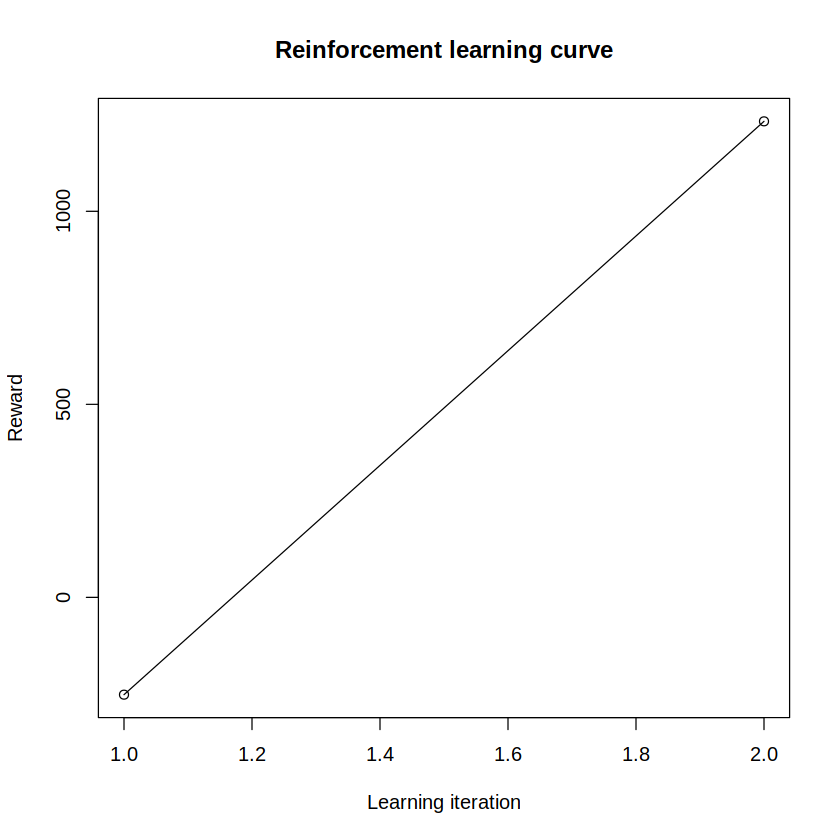

In [21]:
# Plot reinforcement learning curve
plot(model_new)

## Working example 2: Tic-Tac-Toe

This section demonstrates the capabilities of the ReinforcementLearning package when using state-transition tuples from an external source without the need for modeling the dynamics of the environment.

## Problem definition
The following example utilizes the aforementioned dataset containing 406,541 game states of Tic-Tac-Toe to learn the optimal actions for each state of the board (adapted from Sutton (1998)). All states are observed from the perspective of player X who is also assumed to have played first. The player who succeeds in placing three of their marks in a horizontal, vertical, or diagonal row wins the game. Reward for player X is +1 for ‘win’, 0 for ‘draw’, and -1 for ‘loss’..

The current state of the board is represented by a rowwise concatenation of the players’ marks in a 3x3 grid. For example, “……X.B” denotes a board state in which player X has placed a mark in the third field of the first column whereas player B has placed a mark in the third field of the third column (see visualization below).

In [22]:
## ......X.B

## |  .  |  .  |  .   |
## |------------------|
## |  .  |  .  |  .   |
## |------------------|
## |  X  |  .  |   B  |

The following code utilizes the dataset to learn the optimal actions for each state of the board. The computation time is 1-2 minutes on standard desktop computers.

In [23]:
# Load dataset
data("tictactoe")

# Define reinforcement learning parameters
control <- list(alpha = 0.2, gamma = 0.4, epsilon = 0.1)

# Perform reinforcement learning
model <- ReinforcementLearning(tictactoe, s = "State", a = "Action", r = "Reward", 
                               s_new = "NextState", iter = 1, control = control)

# Calculate optimal policy
pol <- computePolicy(model)

# Print policy
head(pol)

BXBB.XXXB XXBB.XBXB X.BBX.X.B XX.BB..BX .BX.BBX.X BX.X.B.BX 
     "c5"      "c5"      "c1"      "c3"      "c8"      "c1"

The ReinforcementLearning() function returns an rl object. Subsequently, evoking computePolicy(model) returns a named vector which allows one to display the policy that defines the best possible action in each state. Here, the names represent the state names (representation of the current board in a match) while the values denote the optimal action. For example, in state “.XXBB..XB” (see grid below), the optimal action for the agent is to place a mark in “c1”.

In [24]:
## |  .  |  X  |  X   |
## |------------------|
## |  B  |  B  |  .   |
## |------------------|
## |  .  |  X  |   B  |

## |  c1  |  c2  |  c3   |
## |---------------------|
## |  c4  |  c5  |  c6   |
## |---------------------|
## |  c7  |  c8  |   c9  |

## Notes on performance
Q-learning is guaranteed to converge to an optimal policy. However, the method is computationally demanding as it relies on continuous interactions between an agent and its environment. To remedy this, the ReinforcementLearning package allows users to perform batch reinforcement learning. In most scenarios, this reinforcement learning variant benefits computational performance as it mitigates the ‘exploration overhead’ problem in pure online learning. 

In combination with experience replay, it speeds up convergence by collecting and replaying observed state transitions repeatedly to the agent as if they were new observations collected while interacting with the system. Nonetheless, due to the fact that the package is written purely in R, the applicability of the package to very large scale problems (such as applications from computer vision) is still limited. In the following, we briefly summarize scenarios the package is capable of handling and situations in which one should consider utilizing reinforcement learning implementations written in “faster” programming languages.

What the ReinforcementLearning R package can do:

* <b>Learning optimal strategies for real-world problems with limited state and action sets</b> (e.g. finding optimal strategies for simple games, training a simple stock market trading agent, learning polarity labels in applications from natural language processing).
* The packages <b>allows one to speed up performance by adjusting learning parameters and making use of experience replay.</b>
* The package <b>allows one to train an agent from pre-defined observations without the need for modeling the dynamics of the environment.</b> Typically, this approach drastically speeds up convergence and can be useful in situations in which the state-transition tuples have been collected from an external source, such as sensor data.
* The package <b>provides a highly customizable framework for model-free reinforcement learning tasks in which the functionality can easily be extended.</b> For example, users may attempt to speed up performance by defining alternative reinforcement learning algorithms and integrating them into the package code.

What the ReinforcementLearning R package cannot do:

* Solving large-scale problems with high-dimensional state-action spaces such as those from computer vision (users may consider reinforcement learning implementations written in “faster” programming languages)
* Solving reinforcement learning problems requiring real-time interaction (e.g. real-time interaction with a robot)